# Introduction

Today, we are going to have a beginner's look into an interesting approach in Deep Learning, called **Transfer Learning**. We are also going to build a simple Computer Vision model to demonstrate a working example of Transfer Learning. Our model will be a classifier that differentiates between Millipedes, Centipedes and Spiders.

We are going to be using [fastai](https://github.com/fastai/fastai) and [PyTorch](https://github.com/pytorch/pytorch) for this tutorial. More specifically, we are going to be using Google's free service [Colab](https://colab.research.google.com/) that gives us free GPU to do Deep Learning.

# What is Transfer Learning?
So what really is it Transfer Learning?

In simple terms, Transfer Learning is the approach of transferring knowledge from one Deep Learning Model to another. In more technical terms, Transfer Learning is the approach of using an already pretained model, and adapting it to a new problem.

This simple approach helps developers get state of the art results with little data and little compute.

Training a model from scratch requires a lot of compute and a lot of data. For example the pretrained model we are going to use was trained on ImageNet database which contains 1.2 million images with 1000 categories. In practice, very few people train the enitre Network from scratch, we often leverage the knowledge gained from these pretrained models and adapt them to our specific dataset.


To learn more about Transfer Learning, you can use [these notes.](https://cs231n.github.io/transfer-learning/)

# A Little Intuition Before We Begin.

Deep Learning models consists of many layers inside them, each learning its own unique features. In 2013, two researches published a paper called [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901) that helped visualize what is going on inside the layers and what they actually learn. In the interest of keeping this post beginner friendly, I won't go much into the technical details of the paper but, here are some images showing what the layers in the neural network learn.

In the first layer, the two reasearchers showed that the network learns general features like diagonal, vertical and horizontal edges. These are the building blocks.

![First layer of the CNN (courtesy of Matthew D. Zeiler and Rob Fergus)](layer_1.JPG)

In the second layer, the Network starts to learn simple patterns that are also general to any Computer Vision Data like circles, etc.
![Second of the CNN (courtesy of Matthew D. Zeiler and Rob Fergus)](layer_2.JPG)

And it keeps on improving layer by layer, building from the building blocks.

![Third layer of the CNN (courtesy of Matthew D. Zeiler and Rob Fergus)](layer_3.JPG)

So as you can see, the first layers of a Convolutional Network learn general patterns that are common to all images. This is why we don't want to discard these knowledge because it can be used for any dataset.

What actually happens in transfer learning, specifically for Computer Vision Tasks is the first layers are freezed (no learning goes on) and the final layer (the one that actually does the classification e.g dog from cat) is chopped of and replaced with a classification layer that is specific to the dataset, i.e our final layer will be trained to specifically distinguish Millipedes, Centipedes and Spiders.


Let's get straight into the practical example, shall we?

# Training A Computer Vision Model Using Transfer Learning

In [ ]:
#| include: false
!pip install -Uqq fastbook
!pip install -Uqq jmd_imagescraper
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.6MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.0MB 16.7MB/s 
     |████████████████████████████████| 358kB 41.6MB/s 
     |████████████████████████████████| 40kB 7.5MB/s 
     |████████████████████████████████| 40kB 7.3MB/s 
     |████████████████████████████████| 92kB 14.1MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 2.6MB 49.7MB/s 
Mounted at /content/gdrive


In [ ]:
#| include: false
from fastbook import *

Let's start by handling our imports:

In [ ]:
from fastai.vision.all import *

For the DataSet, we are going to scrap the internet for centipedes, millipedes and spiders. We are going to use a very handy tool, [jmd_imagescraper](https://joedockrill.github.io/jmd_imagescraper/), that uses DuckDuckGo for the image scraping and returns some nice images. The developer also provides a nice ImageCleaner that we are going to use later to clean up the dataset. Let's import them too.

In [ ]:
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *

We create a directory called 'data'. We then use the image scrapper to get the images of the three classes we are interested in and save them each to their specific directories inside the 'data' directory, i.e. the centipedes will be stored inside a directory called 'Centipedes' and the millipedes will be stored inside the 'Millipede' directory and likewise for the spiders (This arrangement is going to prove useful later!). We download 150 images for each.

In [ ]:
root = Path().cwd()/"data"

duckduckgo_search(root, 'Centipede', 'centipede', max_results=150)
duckduckgo_search(root, 'Millipede', 'millipede', max_results=150)
duckduckgo_search(root, 'Spider', 'spider', max_results=150)

Let us see how our 'data' directory looks after the downloading completes:

In [ ]:
path = Path('data')

In [ ]:
#| include: false
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('Spider'),Path('Centipede'),Path('Millipede')]

As you can see, we have three directories inside, each corresponding to the images it containes. If we look inside a specific directory, e.g. Centipede, we see the individual images downloaded, and the total number of images downloaded (150) prefixed before the list:

In [ ]:
(path/'Centipede').ls()

(#150) [Path('Centipede/135_dd009ed0.jpg'),Path('Centipede/084_69e0099b.jpg'),Path('Centipede/129_5409e84e.jpg'),Path('Centipede/077_cc3b3dd9.jpg'),Path('Centipede/097_cdfd1abf.jpg'),Path('Centipede/030_55b8c176.jpg'),Path('Centipede/090_ef7667e5.jpg'),Path('Centipede/028_5b5b8f46.jpg'),Path('Centipede/052_ec993151.jpg'),Path('Centipede/056_86c51270.jpg')...]

Okay, now that we have got our images ready, we can begin the next step which is processing them. We use a handy function provided by fastai called get_image_files, which simply recursively goes through the directory and gets all the images inside them. 

In [ ]:
fns = get_image_files(path)
fns

(#450) [Path('Spider/019_ffed6440.jpg'),Path('Spider/100_59bd4277.jpg'),Path('Spider/056_21ce5818.jpg'),Path('Spider/114_33c06a31.jpg'),Path('Spider/001_f7a867bc.jpg'),Path('Spider/139_3d7b9ec9.jpg'),Path('Spider/007_f8419240.jpg'),Path('Spider/113_3082658a.jpg'),Path('Spider/135_347f4e6e.jpg'),Path('Spider/144_e94c648a.jpg')...]

We have 450 images, which makes sense. Did any image get corrupted during downloading? Let us verify the images.

In [ ]:
failed = verify_images(fns)
failed

(#0) []

Luckily, no image got corrupted. Good, now let's go on.

Let us open one and see how it looks:

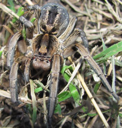

In [ ]:
im = Image.open(fns[2])
im.to_thumb(128, 128)

So far everything is looking good!

Since we have gotten the images, now we can start processing them in a format that our learner expects. We are going to use the DataBlock API from fastai.

I am going to give a brief explanation of what is going on, but I highly recommend going through their documentaion about the [DataBlock API](https://), where they explain everything in detail.

Let us first see how the code looks like:

In [ ]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
)

Let us go step by step:

> blocks=(ImageBlock, CategoryBlock)

This simply tells the dataloader the format of the data it is receiving, i.e. here, our independent variable is going to be and Image, hence the ImageBlock, and the labels or the dependent variables are going to be a category (either 'Centipede', 'Millipede', or 'Spider')

> get_items=get_image_files

This tells our dataloader how to get the items, using the get_image_files we used before

> get_y=parent_label

This instructs our dataloader on how to get the labels of the images, by getting the parent name of the directory the image is in (That's why we arranged the pictures in images in their repsective directories).

> splitter=RandomSplitter(valid_pct=0.2, seed=42)

This provides a way of splitting the dataset into a training and a validation set. Here we split the validation set into 20% of the total data. The seed option is there to ensure we get the same validation set every time.

> item_tfms=RandomResizedCrop(224, min_scale=0.3)

This is simply a transformation done on every image individually. Here we resize the images to 224 x 224. Images should be the same size when fed into the Neural Network. We go an extra step of randomly picking a different crop of the images every time, i.e. a minimum of 30% of the total image every time. Randomly picking a different section of the image every time helps the Network generalize well to new data.

And finally this,

> batch_tfms=aug_transforms()

performs data augmentation on the images. Data Augmentation deserves a whole post by itself to explain, but for intuition on why we do this, let me give a brief explanation. When using our model in the real world, people will provide images in very different formats, taken from different angles, some from cameras with low pixel capturing capabilities which provides somewhat blurry images. But we still need the model to generalize well to all of these cases! Hence data augmentation. Data Augmentation transforms the images to different versions, flipping it, rotating it, darkening it and many other transforms, to help the model generalize well in the real world. We use a batch transform here that applies the transforms in batches in the GPU which is way faster.

Let us load the images into a dataloader, which is what the learner expects, and show one batch of the images.

In [ ]:
dls = images.dataloaders(path)

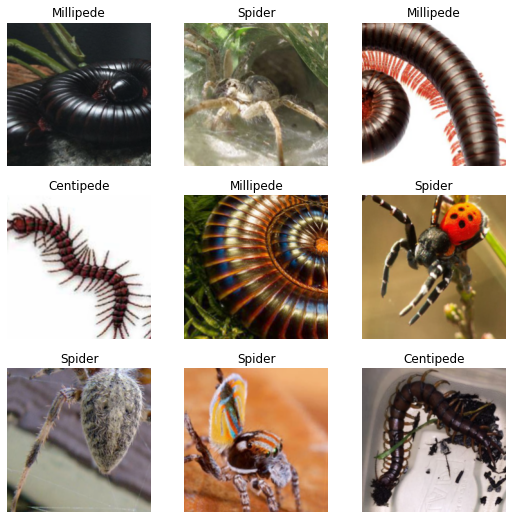

In [ ]:
dls.show_batch(max_n=9)

As you can see, the images are being Randomly Resized, cropping every time to 30% of the image.

Let us see what the augmentation transforms did to our data, by adding the unique parameter:

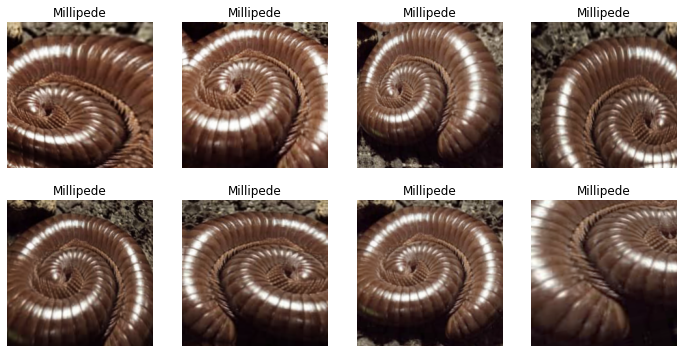

In [ ]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

As you can see, these all are the same images but transformed differently.

Now we are ready to create the model.

# Training The Model

Remember all the talk of using a pretrained model? Well, here is where we apply it.

We are using the *resnet18* pretrained model from PyTorch and fine tuning it for 5 epochs for our specific dataset. The '18' suffix simply means it has 18 layers, which is going to be sufficient for our simple model. However, there are deeper models like *resnet34*, *resnet50*, *resnet101* and *resnet152* with the respective number of layers. Deeper models take more time to train, and often produce better results but not always! As a rule of thumb, start simple then upgrade if need be.

We load our dataloaders (dls) created earlier and we are going to output 'error_rate' and 'accuracy' as our metrics, to guide us on how well our model is performing.

We are going to use a cnn_learner which is simply a Convolutional Neural Network Learner which is the type of Neural Network widely used for Computer Visions tasks.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.545470,0.389558,0.155556,0.844444,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.454676,0.267906,0.100000,0.900000,00:03
1,0.342936,0.232648,0.066667,0.933333,00:03
2,0.291200,0.193626,0.077778,0.922222,00:03
3,0.237957,0.190752,0.066667,0.933333,00:03
4,0.205695,0.206321,0.066667,0.933333,00:03


After 5 epochs, we get an error rate of 6.7% which corresponds to an accuracy of 93.3%. That is really good considering our small dataset and the time we used to train this model, approximately 20 seconds, but as you will see, we can improve this.

You may be asking yourself why we didn't clean the dataset first before training. It is good to train your model as soon as possible to provide you with a baseline which you can start improving from. And we will clean the dataset later, with the help of the training results and then retrain with a clean dataaset and see if it improves.

Let us inspect what errors our initial model is making. The Classification Confusion Matrix can aid in displaying this in a good format.

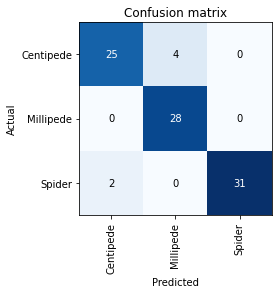

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

The dark colors on that diagonal indicate that the model is perfoming well. But it is still making mistakes, for example it classified Centipedes as Millipedes 4 times and Spiders as Centipedes twice.

Let us see the specific images it is getting wrong and try to understand why it is confusing them by plotting the top losses of our model.

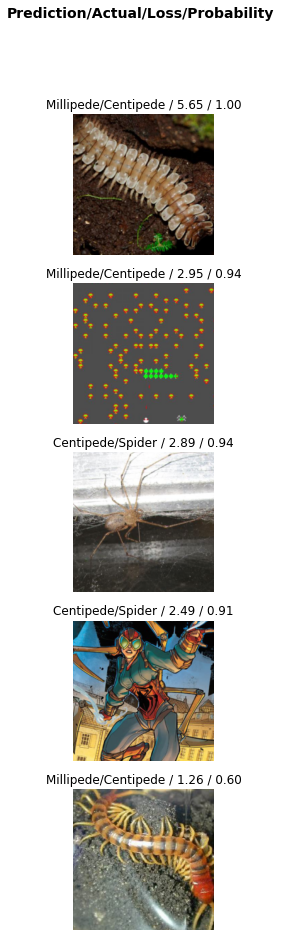

In [ ]:
interp.plot_top_losses(5, nrows=5)

Straight away we can see that some of the mistakes it is making is because of unclean data. For example the 2nd and 4th images have nothing to do with our data. 

This is why we need to clean the data. As you can see, training the model first helps us with the cleaning process.

We are going to use the ImageCleaner provides by the jmd_imagescrapper developer.


In [ ]:
display_image_cleaner(root)


![Cleaner](cleaner.JPG)

I did deleted a few of the images from the datasets that didn't fit the criteria and we were left with 394 images (but useful ones!).

In [ ]:
fns = get_image_files(path)
fns

(#394) [Path('Spider/019_ffed6440.jpg'),Path('Spider/100_59bd4277.jpg'),Path('Spider/056_21ce5818.jpg'),Path('Spider/114_33c06a31.jpg'),Path('Spider/001_f7a867bc.jpg'),Path('Spider/139_3d7b9ec9.jpg'),Path('Spider/007_f8419240.jpg'),Path('Spider/113_3082658a.jpg'),Path('Spider/135_347f4e6e.jpg'),Path('Spider/144_e94c648a.jpg')...]

Okay, now we create a new dataloader with the clean images.

In [ ]:
dls = images.dataloaders(path)

Will training with only clean data help improve our model? Lets train a new model and see. We are going to use the exact details we used before, but I am fine-tuning for 10 epochs this time.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.070883,0.254761,0.076923,0.923077,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.478606,0.169040,0.038462,0.961538,00:02
1,0.413722,0.118356,0.038462,0.961538,00:02
2,0.333819,0.103353,0.038462,0.961538,00:02
3,0.260725,0.119273,0.025641,0.974359,00:02
4,0.213143,0.118922,0.025641,0.974359,00:02
5,0.185268,0.092165,0.025641,0.974359,00:02
6,0.156762,0.087852,0.012821,0.987179,00:02
7,0.138017,0.083028,0.025641,0.974359,00:02
8,0.118409,0.083742,0.025641,0.974359,00:02
9,0.111713,0.082776,0.025641,0.974359,00:02


We went upto an error rate of just 2.6% which means that our model is correct 97.4% of the time!

As you have seen practically, Transfer Learning is a very important technique in Deep Learning that can go a long way. We only used 394 images here and trained for approximately for 20 seconds and got a model which is pretty accurate.

Stay tuned for more.